# Simple fMRI preprocessing pipeline
This notebook describes a simple preprocessing pipeline for fMRI data, using the [nipype](http://nipy.org/nipype/) environment/package (Gorgolewski K., et al., 2011, Front. Neurinform. 5:13), in which a combination of FSL-software and custom Python scripts are used. 

Lukas Snoek, University of Amsterdam (lukassnoek@gmail.com)

## Packages and settings
Below, necessary packages are imported and some pipeline-specific variables are defined.

In [11]:
# Importing necessary packages
import os
import os.path as op
import glob
import nipype
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nibabel as nib
from IPython.display import Image
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from IPython.display import Image

# Importing of custom nodes from spynoza packages; assumes that spynoza is installed:
# pip install git+https://github.com/spinoza-centre/spynoza.git@master
from spynoza.nodes import apply_sg_filter, find_middle_run, get_scaninfo
from spynoza.create_dir_structure import DataOrganizer

%matplotlib inline

## Setting up the project structure
To use Nipype effectively, it's nice to have your data structured in a way such that it is easy to glob
files. Here, a custom class (DataOrganizer) is used to set up a project structure/skeleton and to
perform some minor preprocessing (PAR/REC conversion). After initializing the DataOrganizer, you can download the data using the `fetch_test_data` method.

In [4]:
project_dir = os.path.join(os.path.expanduser('~'), 'simple_preproc')
subject_stem = 'sub'

run_names = {'func': ['hww', 'zinnen1', 'zinnen2'],
             'struc': 'T1'}

data_organizer = DataOrganizer(run_names=run_names, project_dir=project_dir, 
                               subject_stem=subject_stem, already_converted=True)
print('Data will be processed in: \n%s' % data_organizer.project_dir)

Data will be processed in: 
/home/lukas/simple_preproc


To run the pipeline described below, you can download some example data from my dataset:

In [5]:
data_organizer.fetch_test_data()

'Already downloaded!'

In [6]:
# The method-calls below set up the project structure.
data_organizer.convert_parrec2nifti()
data_organizer.create_project_tree()

Done with conversion of par/rec to nifti.


## Setting up the workflow
Definition of nodes within pipeline + inputs (infosource / selectfiles) + outputs (datasink)

In [19]:
# i/o
subject_list = [op.basename(f) for f in data_organizer.subject_dirs] # we'll iterate over this list!
wd = data_organizer.working_dir # working directory
datasink_dir = 'datasink_preprocessing'        

# Analysis parameters
frac_T1 = 0.4
frac_epi = 0.2
robust_bet = True
fwhm = 5.0
mcflt_cost = 'mutualinfo'

### Input/output nodes
First, the input nodes (infosource / selectfiles) and output nodes (datasink) are defined.

In [22]:
# Infosource simply distributes iterables (here: subjects) for parallel processing
infosource = pe.Node(IdentityInterface(fields=['subject_id']), name="infosource")
infosource.iterables = [('subject_id', subject_list)]
# you can also specify other iterables, such as models or runs 

# The template is used to glob files
template = {
    'func': '%s/{subject_id}/func_*/*.nii.gz' % wd,
    'struc': '%s/{subject_id}/T1/*.nii.gz' % wd,
    'log': '%s/{subject_id}/*/*.log' % wd}

selectfiles = pe.Node(SelectFiles(template, base_directory=wd), name="selectfiles")

datasink = pe.Node(DataSink(base_directory=data_organizer.project_dir, container=datasink_dir), name="datasink")
substitutions = [('_subject_id_', '')]
datasink.inputs.substitutions = substitutions

### T1 processing stream

In [23]:
reorient_T1 = pe.Node(interface=fsl.Reorient2Std(), name='reorient_T1')
bet_T1 = pe.Node(interface=fsl.BET(frac=frac_T1, robust=robust_bet), name='bet_T1')
fast = pe.Node(interface=fsl.FAST(), name='segment')

### EPI processing stream

In [15]:
reorient_epi = pe.MapNode(interface=fsl.Reorient2Std(), name='reorient_epi', iterfield='in_file')
bet_epi = pe.MapNode(interface=fsl.BET(frac=frac_epi, functional=True), name='bet_epi', iterfield='in_file')

findmiddlerun = pe.Node(util.Function(input_names=['in_files'],
                                           output_names=['middle_run', 'other_runs'],
                                           function=find_middle_run),
                        name='find_middle_run')

mean_bold = pe.Node(interface=fsl.maths.MeanImage(dimension='T'), name='mean_bold')

# Note that the mcflirt-node for the middle run is a Node and the mcflirt-node for the rest of the runs is
# a MapNode (because it takes in a list of files).
mcflirt_middle = pe.Node(interface=fsl.MCFLIRT(cost=mcflt_cost, interpolation='sinc', stages=3, save_plots=True),
                            name='mcflirt_middle')

mcflirt_rest = pe.MapNode(interface=fsl.MCFLIRT(cost=mcflt_cost, interpolation='sinc', stages=3, save_plots=True),
                       name='mcflirt_rest', iterfield='in_file')

plot_motion = pe.MapNode(interface=fsl.PlotMotionParams(in_source='fsl'),
                        name='plot_motion',
                        iterfield=['in_file'])

# Iterate over rotations and translations!
plot_motion.iterables = ('plot_type', ['rotations', 'translations'])

slicetimer = pe.MapNode(interface=fsl.SliceTimer(interleaved=False), 
                        name='slicetimer', 
                        iterfield=['in_file', 'time_repetition'])

smooth = pe.MapNode(interface=fsl.IsotropicSmooth(fwhm=fwhm), 
                    name='smooth', iterfield=['in_file'])

sgfilter = pe.MapNode(util.Function(input_names=['in_file'],
                                    output_names=['out_file'],
                                    function=apply_sg_filter),
                      iterfield=['in_file'],
                      name='sgfilter')



### Misc. nodes

In [24]:
extract_scaninfo = pe.MapNode(util.Function(input_names=['in_file'],
                                        output_names=['TR', 'shape', 'dyns', 'voxsize', 'affine'],
                                        function=get_scaninfo),
                          name='extract_scaninfo',
                          iterfield='in_file')

# These files merge inputs from different nodes in a list to be used by downstream MapNodes.
mcflirt_merger_infiles = pe.Node(interface=util.Merge(2), name='mcflirt_merger_infiles')
mcflirt_merger_motionplots = pe.Node(interface=util.Merge(2), name='mcflirt_merger_motionplots')

### Connect nodes together!

INFO:workflow:Creating detailed dot file: /home/lukas/simple_preproc/test_data/preproc/graph_detailed.dot
INFO:workflow:Creating dot file: /home/lukas/simple_preproc/test_data/preproc/graph.dot


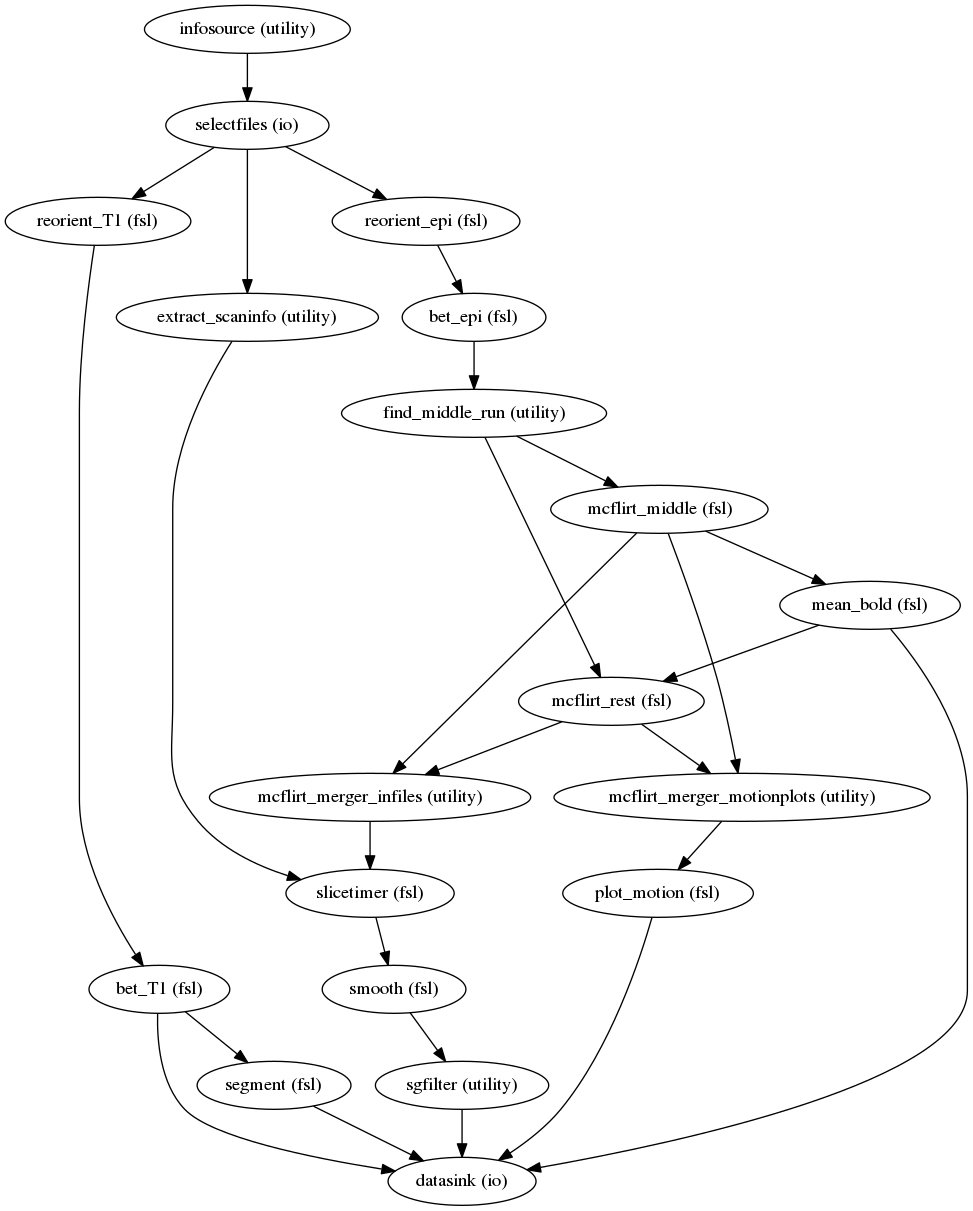

In [27]:
preproc = pe.Workflow(name='preproc')
preproc.base_dir = data_organizer.project_dir
preproc.connect(infosource, 'subject_id', selectfiles, 'subject_id')

preproc.connect(selectfiles, 'struc', reorient_T1, 'in_file')
preproc.connect(reorient_T1, 'out_file', bet_T1, 'in_file')
preproc.connect(bet_T1, 'out_file', datasink, 'bett1')
preproc.connect(bet_T1, 'out_file', fast, 'in_files')
preproc.connect(fast, 'tissue_class_files', datasink, 'fast')

preproc.connect(selectfiles, 'func', reorient_epi, 'in_file')
preproc.connect(reorient_epi, 'out_file', bet_epi, 'in_file')

preproc.connect(bet_epi, 'out_file', findmiddlerun, 'in_files')
preproc.connect(findmiddlerun, 'middle_run', mcflirt_middle, 'in_file')
preproc.connect(mcflirt_middle, 'out_file', mean_bold, 'in_file')
preproc.connect(mean_bold, 'out_file', mcflirt_rest, 'ref_file')
preproc.connect(findmiddlerun, 'other_runs', mcflirt_rest, 'in_file')
preproc.connect(mcflirt_middle, 'out_file', mcflirt_merger_infiles, 'in1')
preproc.connect(mcflirt_rest, 'out_file', mcflirt_merger_infiles, 'in2')
preproc.connect(mcflirt_merger_infiles, 'out', slicetimer, 'in_file')

preproc.connect(mcflirt_middle, 'par_file', mcflirt_merger_motionplots, 'in1')
preproc.connect(mcflirt_rest, 'par_file', mcflirt_merger_motionplots, 'in2')
preproc.connect(mcflirt_merger_motionplots, 'out', plot_motion, 'in_file')
preproc.connect(plot_motion, 'out_file', datasink, 'mcplots')
preproc.connect(mean_bold, 'out_file', datasink, 'meanbold')

preproc.connect(slicetimer, 'slice_time_corrected_file', smooth, 'in_file')
preproc.connect(smooth, 'out_file', sgfilter, 'in_file')
preproc.connect(selectfiles, 'func', extract_scaninfo, 'in_file')
preproc.connect(extract_scaninfo, 'TR', slicetimer, 'time_repetition')

preproc.connect(sgfilter, 'out_file', datasink, 'fullypreproc')

preproc.write_graph(simple_form=True, graph2use='flat')
Image(filename=os.path.join(data_organizer.project_dir, preproc.name, 'graph.dot.png'))

# Check out a more detailed graph by:
#Image(filename=os.path.join(data_organizer.project_dir, preproc.name, 'graph_detailed.dot.png'))

In [ ]:
# Run workflow!
preproc.config = {'execution' : {'stop_on_first_crash' : True,
                                 'keep_inputs': True,
                                 'remove_unnecessary_outputs': False}}
graph = preproc.run('MultiProc', plugin_args={'n_procs': 5})

/home/lukas/anaconda2/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/lukas/anaconda2/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 2 jobs
INFO:workflow:Executing: selectfiles.b0 ID: 0
INFO:workflow:Executing: selectfiles.b1 ID: 1
INFO:workflow:[Job finished] jobname: selectfiles.b0 jobid: 0
INFO:workflow:Executing node selectfiles.b0 in dir: /home/lukas/simple_preproc/test_data/preproc/_subject_id_sub004/selectfiles
INFO:workflow:Executing node selectfiles.b1 in dir: /home/lukas/simple_prepr